In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

# Import dataset data
from reader import read_data_sets



'''
To forecast time series using a recurrent neural network, we consider every 
row as a sequence of short time series. Because dataset times series has 9 dim, we will then
handle 9 sequences for every sample.
'''
# end of sequences
EOS = 1

# Training Parameters
learning_rate = 0.01
training_steps = 1000
timesteps=20
batch_size = 128
display_step = 200

dataset, stats = read_data_sets("./data.npy", timesteps, timesteps)

# Network Parameters
num_input = 1 # dataset data input (time series dimension: 3)
num_hidden = 128 # hidden layer num of features
num_layers = 2 # number of layers

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, timesteps, num_input])

# Decoder input
Z = tf.placeholder("float", [None, timesteps, num_input])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_input]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_input]))
}

def RNN(enc_inp, dec_inp,  weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    enc_inp = tf.unstack(enc_inp, timesteps, 1)

    # Define a lstm cell with tensorflow
    def lstm_cell():
        return tf.contrib.rnn.BasicLSTMCell(num_hidden,forget_bias=1.0)


#     lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    stacked_lstm = tf.contrib.rnn.MultiRNNCell(
        [lstm_cell() for _ in range(num_layers)])

    # Get lstm cell output --use as encoder
    enc_outputs, enc_states = rnn.static_rnn(stacked_lstm, enc_inp, dtype=tf.float32)
    
    dec_outputs, dec_states = rnn.static_rnn(stacked_lstm, dec_inp, initial_state = enc_states, dtype=tf.float32)
    
    # Concatenate all hidden states
    logits = []
    for output in dec_outputs:
        logit = tf.matmul(output, weights['out']) + biases['out']
        logits.append(logit) 
    logits= tf.stack(logits, 1)
    return logits

logits = RNN(X, Z,  weights, biases)
# Using tanh activation function
prediction = tf.nn.tanh(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.squared_difference(prediction, Y))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss 
            loss = sess.run(loss_op, feed_dict={X: batch_x,Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) )

    print("Optimization Finished!")

    # Calculate accuracy for 128 dataset test inps
    test_len = 128
    test_data = dataset.test.inps[:test_len].reshape((-1, timesteps, num_input))
    test_label = dataset.test.outs[:test_len]
    
    # Fetch the predictions 
    fetches = {
        "true":Y,
        "pred":prediction,
        "loss":loss_op
    }
    vals = sess.run(fetches, feed_dict={X: test_data, Y: test_label})
    print("Testing Loss:", vals["loss"])

loading time series ...
input type  <class 'numpy.ndarray'> (10000, 1)
normalize to (0-1)
Step 1, Minibatch Loss= 0.1333


KeyboardInterrupt: 

### visualize the predictions (LSTM no error prop)

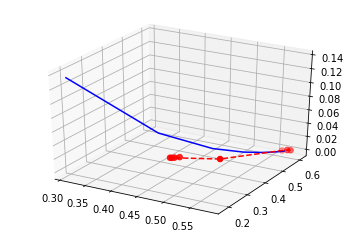

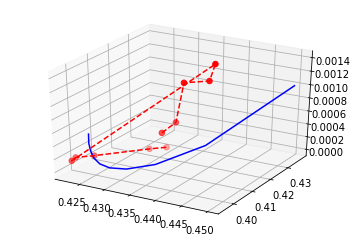

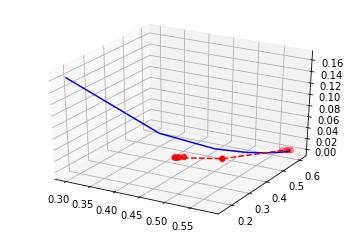

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')

pred = test_vals['pred']
true = test_vals['true']
plot_sample(pred, true,3)
plot_sample(pred, true,6)
plot_sample(pred, true,10)

### Visualize prediction  (LSTM with error prop)

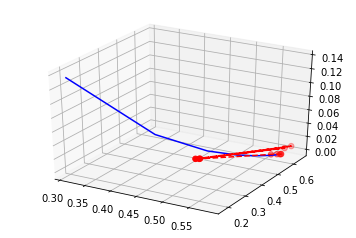

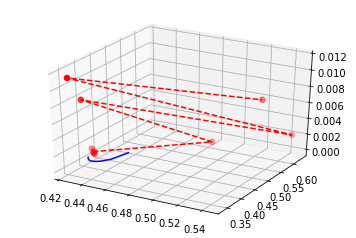

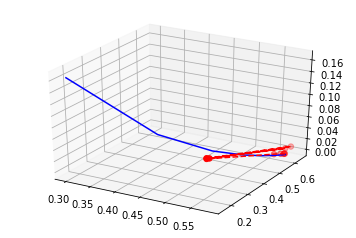

In [6]:
pred = test_vals['pred']
true = test_vals['true']
plot_sample(pred, true,3)
plot_sample(pred, true,6)
plot_sample(pred, true,10)
np.save('../experiments/result/lstm_10_err.npy',test_vals)

### Visualize prediction  (TRNN with error prop)

In [18]:
import numpy as np
print( vals["loss"])
sample_id= 2
print(np.size(pred[sample_id,:,:]))
np.linalg.norm(pred[sample_id,:,:]-true[sample_id,:,:], 'fro')**2/(np.size(pred[sample_id,:,:]))

0.00467936
30


0.005421559774697945

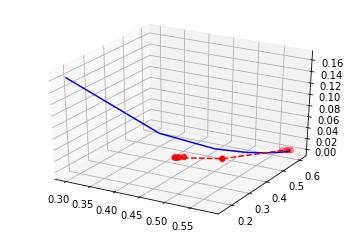

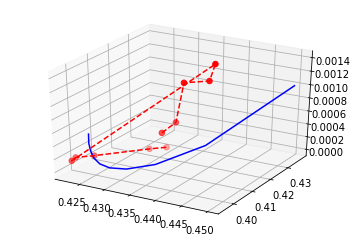

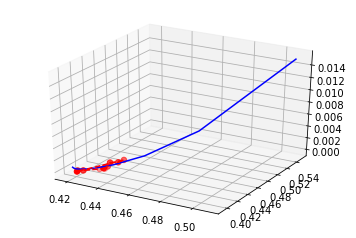

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')

pred = test_vals['pred']
true = test_vals['true']
plot_sample(pred, true,10)
plot_sample(pred, true,6)
plot_sample(pred, true,100)
# np.save('../experiments/result/trnn_10_err.npy',test_vals)